[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)


# snnTorch - Training Spiking Convolutional Neural Networks with snnTorch
## Tutorial 5
### By Jason K. Eshraghian (www.jasoneshraghian.com)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_6_CNN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>



# Introduction
In this tutorial, you will:
* Learn how spiking neurons are implemented as a recurrent network
* Understand backpropagation through time, and the associated challenges in SNNs such as the non-differentiability of spikes
* Train a fully-connected network on the static MNIST dataset

<!-- * Implement various backprop strategies:
  * Backpropagation Through Time
  * Truncated-Backpropagation Through Time
  * Real-Time Recurrent Learning -->

>Part of this tutorial was inspired by Friedemann Zenke's extensive work on SNNs. Check out his repo on surrogate gradients [here](https://github.com/fzenke/spytorch), and a favourite paper of mine: E. O. Neftci, H. Mostafa, F. Zenke, [Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-based optimization to spiking neural networks.](https://ieeexplore.ieee.org/document/8891809) IEEE Signal Processing Magazine 36, 51–63.

At the end of the tutorial, a basic supervised learning algorithm will be implemented. We will use the original static MNIST dataset and train a multi-layer fully-connected spiking neural network using gradient descent to perform image classification. 

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [5]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

# 1. A Recurrent Representation of SNNs

In Tutorial 3, we derived a recursive representation of a leaky integrate-and-fire (LIF) neuron: 

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{R[t]}_\text{reset} \tag{1}$$

where the input synaptic current is interpreted as $I_{\rm in}[t] = WX[t]$, and $X[t]$ may be some arbitrary input of spikes, a step/time-varying voltage, or unweighted step/time-varying current. Spiking is represented with the following equation, where if the membrane potential exceeds the threshold, a spike is emitted:

$$S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases} \tag{2}$$

This formulation of a spiking neuron in a discrete, recursive form is almost perfectly poised to take advantage of the developments in training recurrent neural networks (RNNs) and sequence-based models. This is illustrated using an *implicit* recurrent connection for the decay of the membrane potential, and is distinguished from *explicit* recurrence where the output spike $S_{\rm out}$ is fed back to the input. In the figure below, the connection weighted by $-U_{\rm thr}$ represents the reset mechanism $R[t]$.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/unrolled_2.png?raw=true' width="800">
</center>

The benefit of an unrolled graph is that it provides an explicit description of how computations are performed. The process of unfolding illustrates the flow of information forward in time (from left to right) to compute outputs and losses, and backward in time to compute gradients. The more time steps that are simulated, the deeper the graph becomes. 

Conventional RNNs treat $\beta$ as a learnable parameter. This is also possible for SNNs, though by default, they are treated as hyperparameters. This replaces the vanishing and exploding gradient problems with a hyperparameter search. A future tutorial will describe how to make $\beta$ a learnable parameter.

# 2. The Non-Differentiability of Spikes
## 2.1 Training Using the Backprop Algorithm

An alternative way to represent the relationship between $S$ and $U$ in $(2)$ is:

$$S[t] = \Theta(U[t] - U_{\rm thr}) \tag{3}$$ 

where $\Theta(\cdot)$ is the Heaviside step function:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_2_spike_descrip.png?raw=true' width="600">
</center>

Training a network in this form poses some serious challenges. Consider a single, isolated time step of the computational graph from the previous figure titled *"Recurrent representation of spiking neurons"*, as shown in the *forward pass* below:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/non-diff.png?raw=true' width="400">
</center>

The goal is to train the network using the gradient of the loss with respect to the weights, such that the weights are updated to minimize the loss. The backpropagation algorithm achieves this using the chain rule:

$$\frac{\partial \mathcal{L}}{\partial W} = 
\frac{\partial \mathcal{L}}{\partial S}
\underbrace{\frac{\partial S}{\partial U}}_{\{0, \infty\}}
\frac{\partial U}{\partial I}\
\frac{\partial I}{\partial W}\ \tag{4}$$

From $(1)$, $\partial I/\partial W=X$, and $\partial U/\partial I=1$. While we have not yet defined a loss function, we can assume $\partial \mathcal{L}/\partial S$ has an analytical solution, in a similar form to the cross-entropy or mean-square error loss (more on that shortly). 

However, the term that we are going to grapple with is $\partial S/\partial U$. The derivative of the Heaviside step function from $(3)$ is the Dirac Delta function, which evaluates to 0 everywhere, except at the threshold $U_{\rm thr} = \theta$, where it tends to infinity. This means the gradient will almost always be nulled to zero (or saturated if $U$ sits precisely at the threshold), and no learning can take place. This is known as the **dead neuron problem**. 

## 2.2 Overcoming the Dead Neuron Problem

The most common way to address the dead neuron problem is to keep the Heaviside function as it is during the forward pass, but swap the derivative term $\partial S/\partial U$ for something that does not kill the learning process during the backward pass, which will be denoted $\partial \tilde{S}/\partial U$. This might sound odd, but it turns out that neural networks are quite robust to such approximations. This is commonly known as the *surrogate gradient* approach.

A variety of options exist to using surrogate gradients, and we will dive into more detail on these methods in [Tutorial 6](https://snntorch.readthedocs.io/en/latest/tutorials/index.html). For now, a simple approximation is applied where $\partial \tilde{S}/\partial U$ is set to $S$ itself.

If $S$ does not spike, then the spike-gradient term is $0$. If $S$ spikes, then the gradient term is $1$. This simply looks like the gradient of a ReLU function shifted to the threshold. This method is known as the *Spike-Operator* approach and is described in more detail in the following paper:

> <cite> Jason K. Eshraghian, Max Ward, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv, 2021. </cite>

Inutitively, *Spike Operator* splits the gradient calculation into two chunks: one where the neuron is spiking, and one where it is silent:
* **Silent:** If the neuron is silent, then the spike response can be obtained by scaling the membrane by 0: $S = U \times 0 \implies \partial \tilde{S}/\partial U = 0$. 
* **Spiking:** If the neuron is spiking, then assume $U \approx U_{\rm thr}$, normalize $U_{\rm thr}=1$, and the spike response can be obtained by scaling the membrane by 1: $S = U \times 1 \implies \partial \tilde{S}/\partial U = 1$, where the tilde above $\tilde{S}$ implies an approximation.

This is summarized as follows:

$$\frac{\partial \tilde{S}}{\partial U} \leftarrow S = \begin{cases} 1, &\text{if}~U> U_{\rm thr} \\
0, &\text{otherwise}\end{cases} $$

where the left arrow denotes substitution. 

The same neuron model described in  $(1)-(2)$ (a.k.a., `snn.Leaky` neuron from Tutorial 3) is implemented in PyTorch below. Don't worry if you don't understand this. This will be condensed into one line of code using snnTorch in a moment:

In [6]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.spike_op = self.SpikeOperator.apply
  
  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_op((mem-self.threshold))  # call the Heaviside function
    reset = (spk * self.threshold).detach() # removes spike_op gradient from reset
    mem = self.beta * mem + input_ - reset # Eq (1)
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the Spike itself
  @staticmethod
  class SpikeOperator(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float() # Heaviside on the forward pass: Eq(2)
          ctx.save_for_backward(spk)  # store the spike for use in the backward pass
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (spk,) = ctx.saved_tensors  # retrieve the spike 
          grad = grad_output * spk # scale the gradient by the spike: 1/0
          return grad

Note that the reset mechanism is detached from the computational graph, as the surrogate gradient should only be applied to $\partial S/\partial U$, and not $\partial R/\partial U$.

The above neuron is instantiated using:

In [7]:
lif1 = LeakySurrogate(beta=0.9)

This neuron can be simulated using a for-loop, just as in previous tutorials, while PyTorch's automatic differentation (autodiff) mechanism keeps track of the gradient in the background.

Alternatively, the same thing can be accomplished by calling the `snn.Leaky` neuron. 
In fact, every time you call any neuron model from snnTorch, the *Spike Operator* surrogate gradient is applied to it by default:

In [8]:
lif1 = snn.Leaky(beta=0.9)

If you would like to explore how this neuron behaves, then refer to [Tutorial 3](https://snntorch.readthedocs.io/en/latest/tutorials/index.html).

#3. Backprop Through Time
Equation $(4)$ only calculates the gradient for one single time step (referred to as the *immediate influence* in the figure below), but the backpropagation through time (BPTT) algorithm calculates the gradient from the loss to *all* descendants and sums them together. 

The weight $W$ is applied at every time step, and so imagine a loss is also calculated at every time step. The influence of the weight on present and historical losses must be summed together to define the global gradient:

$$\frac{\partial \mathcal{L}}{\partial W}=\sum_t \frac{\partial\mathcal{L}[t]}{\partial W} = 
\sum_t \sum_{s\leq t} \frac{\partial\mathcal{L}[t]}{\partial W[s]}\frac{\partial W[s]}{\partial W} \tag{5} $$

The point of $(5)$ is to ensure causality: by constraining $s\leq t$, we only account for the contribution of immediate and prior influences of $W$ on the loss. A recurrent system constrains the weight to be shared across all steps: $W[0]=W[1] =~... ~ = W$. Therefore, a change in $W[s]$ will have the same effect on all $W$, which implies that $\partial W[s]/\partial W=1$:

$$\frac{\partial \mathcal{L}}{\partial W}=
\sum_t \sum_{s\leq t} \frac{\partial\mathcal{L}[t]}{\partial W[s]} \tag{6} $$

As an example, isolate the prior influence due to $s = t-1$ *only*; this means the backward pass must track back in time by one step. The influence of $W[t-1]$ on the loss can be written as:

$$\frac{\partial \mathcal{L}[t]}{\partial W[t-1]} = 
\frac{\partial \mathcal{L}[t]}{\partial S[t]}
\underbrace{\frac{\partial \tilde{S}[t]}{\partial U[t]}}_{S[t]}
\underbrace{\frac{\partial U[t]}{\partial U[t-1]}}_\beta
\underbrace{\frac{\partial U[t-1]}{\partial I[t-1]}}_1
\underbrace{\frac{\partial I[t-1]}{\partial W[t-1]}}_{X[t-1]} \tag{7}$$

We have already dealt with all of these terms from $(4)$, except for $\partial U[t]/\partial U[t-1]$. From $(1)$, this temporal derivative term simply evaluates to $\beta$. So if we really wanted to, we now know enough to painstakingly calculate the derivative of every weight at every time step by hand, and it'd look something like this for a single neuron:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/bptt.png?raw=true' width="600">
</center>

But thankfully, PyTorch's autodiff takes care of that in the background for us.  

# 4. Setting up the Loss / Output Decoding
In a conventional, non-spiking neural network, a supervised, multi-class classification problem takes the neuron with the highest activation and treats that as the predicted class. 

In a spiking neural net, there are several options to interpreting the output spikes. The most common approaches are:
* **Rate coding:** Take the neuron with the highest firing rate (or spike count) as the predicted class
* **Latency coding:** Take the neuron that fires *first* as the predicted class

This might feel familiar to [Tutorial 1 on neural encoding](https://snntorch.readthedocs.io/en/latest/tutorials/index.html). The difference is that, here, we are interpreting (decoding) the output spikes, rather than encoding/converting raw input data into spikes.

Let's focus on a rate code. When input data is passed to the network, we want the correct neuron class to emit the most spikes over the course of the simulation run. This then corresponds to the highest average firing frequency. One way to achieve this is to increase the membrane potential of the correct class to $U>U_{\rm thr}$, and that of incorrect classes to $U<U_{\rm thr}$. Applying the target to $U$ serves as a proxy for modulating spiking behavior from $S$.

This can be implemented by taking the softmax of the membrane potential for output neurons, where $C$ is the number of output classes:

$$p_i[t] = \frac{e^{U_i[t]}}{\sum_{i=0}^{C}e^{U_i[t]}} \tag{8}$$

The cross-entropy between $p_i$ and the target $y_i \in \{0,1\}^C$, which is a one-hot target vector, is obtained using:

$$\mathcal{L}_{CE}[t] = \sum_{i=0}^Cy_i{\rm log}(p_i[t]) \tag{9}$$

The practical effect is that the membrane potential of the correct class is encouraged to increase while those of incorrect classes are reduced. In effect, this means the correct class is encouraged to fire at all time steps, while incorrect classes are suppressed at all steps. This may not be the most efficient implementation of an SNN, but it is among the simplest.

This target is applied at every time step of the simulation, thus also generating a loss at every step. These losses are then summed together at the end of the simulation:

$$\mathcal{L}_{CE} = \sum_t\mathcal{L}_{CE}[t] \tag{10}$$

This is just one of many possible ways to apply a loss function to a spiking neural network. A variety of approaches are available to use in snnTorch (in the module `snn.functional`), and will be the subject of a future tutorial.

With all of the background theory having been taken care of, let’s finally dive into
training a fully-connected spiking neural net.

# 5. Setting up the Static MNIST Dataset

In [9]:
# dataloader arguments
batch_size = 128
data_path='../mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

If the above code blocks throws an error, e.g. the MNIST servers are down, then uncomment the following code instead.

In [11]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

In [12]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

# 6. Define the Network

In [13]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [14]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)

The code in the `forward()` function will only be called once the input argument `x` is explicitly passed into `net`.

* `fc1` applies a linear transformation to all input pixels from the MNIST dataset;
* `lif1` integrates the weighted input over time, emitting a spike if the threshold condition is met;
* `fc2` applies a linear transformation to the output spikes of `lif1`;
* `lif2` is another spiking neuron layer, integrating the weighted spikes over time.

# 7. Training the SNN

## 7.1 Accuracy Metric
Below is a function that takes a batch of data, counts up all the spikes from each neuron (i.e., a rate code over the simulation time), and compares the index of the highest count with the actual target. If they match, then the network correctly predicted the target.

In [15]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

## 7.2 Loss Definition
The `nn.CrossEntropyLoss` function in PyTorch automatically handles taking the softmax of the output layer as well as generating a loss at the output. 

In [16]:
loss = nn.CrossEntropyLoss()

## 7.3 Optimizer
Adam is a robust optimizer that performs well on recurrent networks, so let's use that with a learning rate of $5\times10^{-4}$. 

In [17]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

## 7.4 One Iteration of Training
Take the first batch of data and load it onto CUDA if available.

In [18]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

Flatten the input data to a vector of size $784$ and pass it into the network.

In [19]:
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([25, 128, 10])


The recording of the membrane potential is taken across:
* 25 time steps
* 128 samples of data
* 10 output neurons

We wish to calculate the loss at every time step, and sum these up together, as per Equation $(10)$:

In [20]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 63.787


The loss is quite large, because it is summed over 25 time steps. The accuracy is also bad (it should be roughly around 10%) as the network is untrained:

In [21]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 7.81%


A single weight update is applied to the network as follows:

In [22]:
  # clear previously stored gradients
  optimizer.zero_grad()

  # calculate the gradients
  loss_val.backward()

  # weight update
  optimizer.step()

Now, re-run the loss calculation and accuracy after a single iteration:

In [23]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 50.874
Train set accuracy for a single minibatch: 34.38%


After only one iteration, the loss should have decreased and accuracy should have increased. Note how membrane potential is used to calculate the cross entropy
loss, and spike count is used for the measure of accuracy. It is also possible to use the spike count in the loss ([see Tutorial 6](https://snntorch.readthedocs.io/en/latest/tutorials/index.html))

## 7.5 Training Loop

Let's combine everything into a training loop. We will train for one epoch (though feel free to increase `num_epochs`), exposing our network to each sample of data once.

In [24]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 53.44
Test Set Loss: 49.20
Train set accuracy for a single minibatch: 54.69%
Test set accuracy for a single minibatch: 44.53%


Epoch 0, Iteration 50
Train Set Loss: 10.93
Test Set Loss: 12.39
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 92.97%


Epoch 0, Iteration 100
Train Set Loss: 10.04
Test Set Loss: 11.71
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 85.16%


Epoch 0, Iteration 150
Train Set Loss: 12.66
Test Set Loss: 7.10
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 96.88%


Epoch 0, Iteration 200
Train Set Loss: 6.25
Test Set Loss: 10.25
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 92.97%


Epoch 0, Iteration 250
Train Set Loss: 9.12
Test Set Loss: 8.65
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 92.19%


Epoch

If this was your first time training an SNN, then congratulations!

# 8. Results
## 8.1 Plot Training/Test Loss

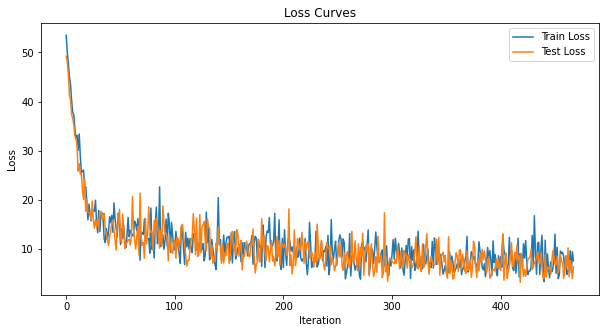

In [25]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

The loss curves are noisy because the losses are tracked at every iteration, rather than averaging across multiple iterations. 

## 8.2 Test Set Accuracy
This function iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

In [26]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9453/10000
Test Set Accuracy: 94.53%


Voila! That's it for static MNIST. Feel free to tweak the network parameters, hyperparameters, decay rate, using a learning rate scheduler etc. to see if you can improve the network performance. 

# Conclusion
Now you know how to construct and train a fully-connected network on a static dataset. The spiking neurons can also be adapted to other layer types, including convolutions and skip connections. Armed with this knowledge, you should now be able to build many different types of SNNs. [In the next tutorial](https://snntorch.readthedocs.io/en/latest/tutorials/index.html), you will learn how to train a spiking convolutional network, and simplify the amount of code required using the `snn.backprop` module.

Also, a special thanks to Bugra Kaytanli for providing valuable feedback on the tutorial.

If you like this project, please consider starring ⭐ the repo on GitHub as it is the easiest and best way to support it.


# Additional Resources

* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)